# SWED Evaluation 
Evaluate different segmentation approaches on the SWED test dataset. These include the deterministic superpixel algorithm, pretrained and finetuned U-Net model. The accuracy, precision, recall, F1 and FOM metrics are calculated. 

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import train
import network
import torch

import glob

import importlib
import evaluation as eval
import utils
importlib.reload(utils)
importlib.reload(eval)

base_path = '../../data/'

# SWED

In [17]:
# Model names
swed_original = "SWED_UNET_12JUL2024.pth" #Model from previos paper (will not give SOTA results due to different architecture)
swed_superpixel = "SWED_SUPERPIXELS_12JUL2024.pth" #Pretrained model trained on superpixel output
swed_finetune = "SWED-FINETUNE-26JUL24.pth" #Fine-tuned model 

In [5]:
# Load LICS data
incl_bands = [0,1,2,3,4,5,6,7,8,9,10,11]
satellite = 'sentinel'

# Test data
target_pos = -1

test_file = base_path + 'SWED/test/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[:,:,target_pos] for file in test_paths]
test_input = [np.load(file)[:,:,incl_bands] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets))
print(np.shape(test_input))

# Finetune data
target_pos = -1

finetune_file = base_path + 'SWED/finetune/'
finetune_paths = glob.glob(finetune_file + '*.npy')
finetune_targets = [np.load(file)[:,:,target_pos] for file in finetune_paths]
finetune_input = [np.load(file)[:,:,incl_bands] for file in finetune_paths]

print("\nFinetune dimensions:")
print(np.shape(finetune_targets))
print(np.shape(finetune_input))

Test dimensions:
(98, 256, 256)
(98, 256, 256, 12)

Finetune dimensions:
(100, 256, 256)
(100, 256, 256, 12)


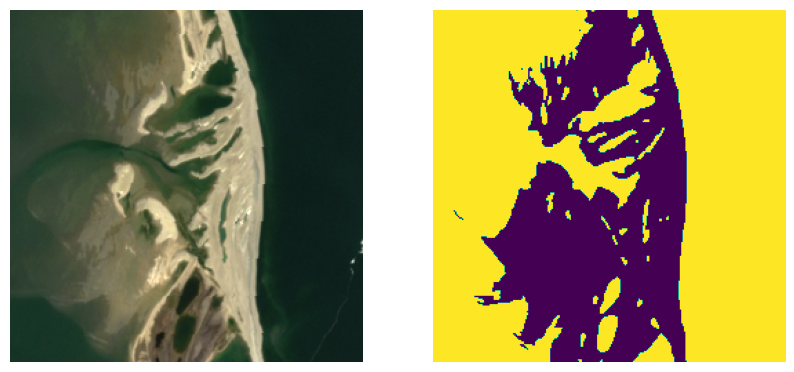

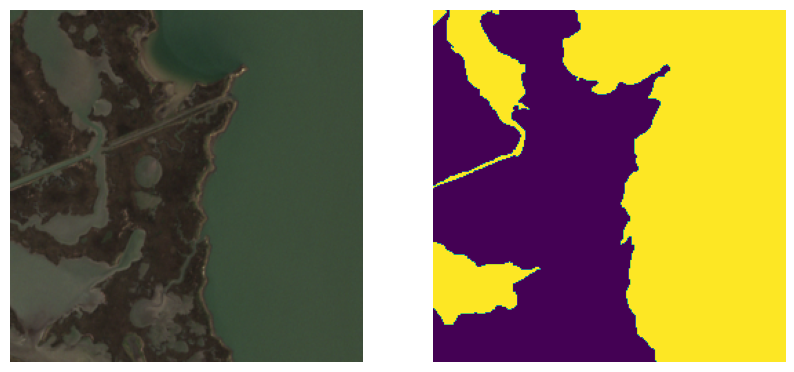

In [10]:
# Sense check the data

# Test data
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],satellite=satellite,contrast=0.2)
target = test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

# Finetune data
i = np.random.randint(0,len(finetune_paths))
rgb = utils.get_rgb(finetune_input[i],satellite=satellite,contrast=0.2)
target = finetune_targets[i]

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

## Superpixel algorithm

In [18]:
# Ititialize metrics
test_metrics = {}
finetune_metrics = {}

In [19]:
def get_sp_predictions(paths,satellite,rgb_bands,index_name,threshold = -1,method='slic', **kwargs):
    # Copy the input image to avoid modifying the original
    preds = []
    for path in paths:
        all_bands = np.load(path)
        mask = utils.get_mask_from_bands(all_bands, 
                                         satellite=satellite,
                                         rgb_bands=rgb_bands,
                                         threshold=threshold, 
                                         index_name=index_name,
                                         method=method, **kwargs)
        preds.append(mask)
    return preds


accuracy: 94.274
balanced_accuracy: 91.8996
precision: 93.8109
recall: 94.3272
f1: 93.2877
mse: 3.6212
fom: 60.1506


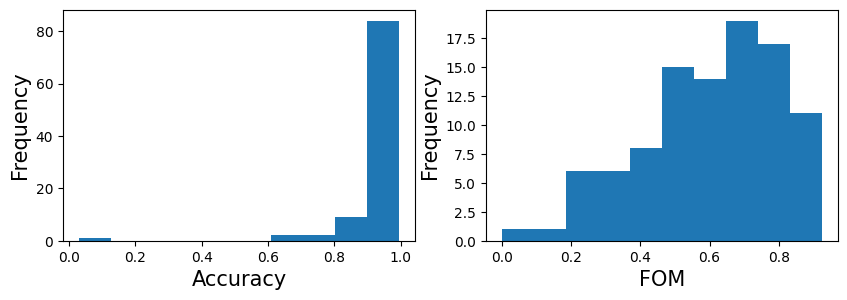

In [20]:
# Test
preds = get_sp_predictions(test_paths,
                           satellite='sentinel',
                           rgb_bands=["nir", "green", "blue"],
                           index_name="NDWI",
                           threshold=0, 
                           method='felzenszwalb',
                           min_size=60)


metrics, arr = eval.eval_metrics(test_targets,preds)
test_metrics['superpixels'] = metrics
eval.display_metrics(metrics,arr)

accuracy: 94.507
balanced_accuracy: 94.6266
precision: 94.162
recall: 93.0487
f1: 92.2374
mse: 4.1147
fom: 69.1608


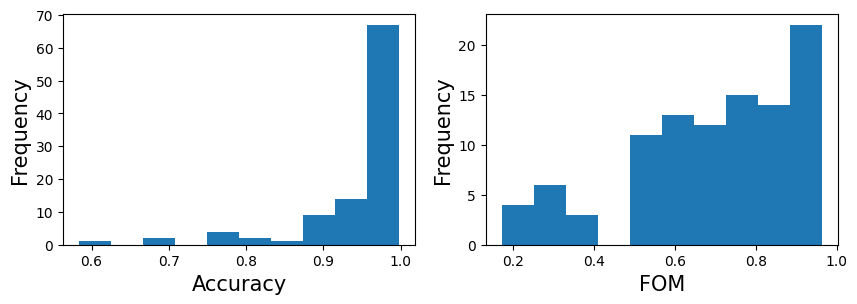

In [21]:
# Finetune
preds = get_sp_predictions(finetune_paths,
                            satellite='sentinel',
                           rgb_bands=["nir", "green", "blue"],
                           index_name="NDWI",
                           threshold=0, 
                           method='felzenszwalb',
                           min_size=60)


metrics, arr = eval.eval_metrics(finetune_targets,preds)
finetune_metrics['superpixels'] = metrics
eval.display_metrics(metrics,arr)

# Original model

In [22]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(12,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{swed_original}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

In [37]:
from train_unet import * #load dataset and model classes

# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

# Load saved model 
model = torch.load('../../models/UNET-SCALE-13MAR23.pth', map_location=torch.device('cpu') )
model.eval()
model.to(device)

ModuleNotFoundError: No module named 'osgeo'

98
accuracy: 88.5019
balanced_accuracy: 85.7067
precision: 89.4053
recall: 84.8352
f1: 84.6556
mse: 5.0162
fom: 53.7762


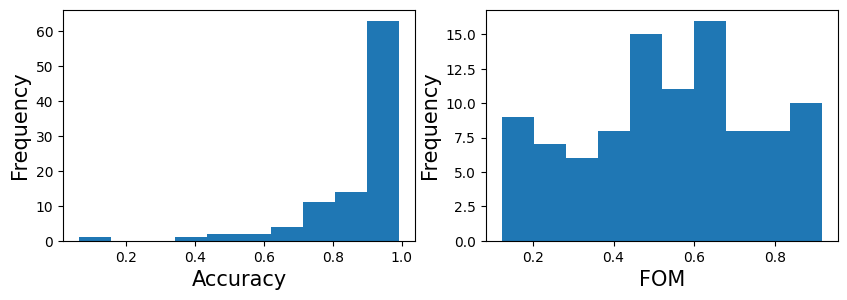

In [23]:
# Test
targets, preds = eval.get_preds(model,test_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(test_targets ,preds)
test_metrics['original'] = metrics
eval.display_metrics(metrics,arr)

100
accuracy: 93.4081
balanced_accuracy: 93.1206
precision: 91.8864
recall: 91.7878
f1: 90.4811
mse: 5.1565
fom: 63.3179


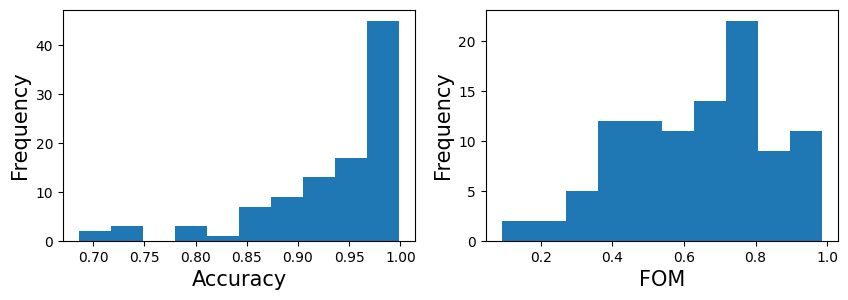

In [24]:
# Finetune
targets, preds = eval.get_preds(model,finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(finetune_targets ,preds)
finetune_metrics['original'] = metrics
eval.display_metrics(metrics,arr)

## Rough model

In [25]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(12,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{swed_superpixel}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

98
accuracy: 86.9636
balanced_accuracy: 86.3301
precision: 82.2504
recall: 94.4404
f1: 85.7802
mse: 5.1182
fom: 42.1348


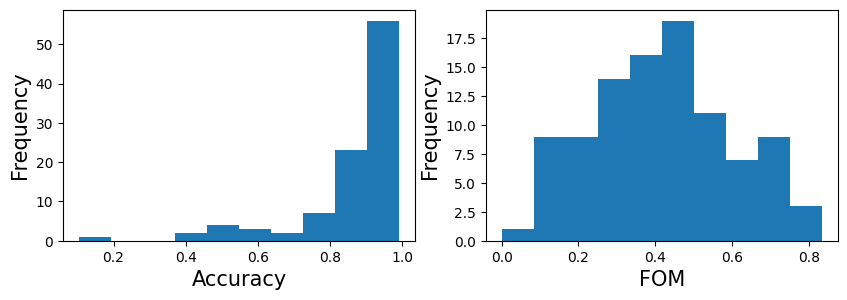

In [26]:
# Test
targets, preds = eval.get_preds(model,test_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(test_targets ,preds)
test_metrics['rough_model'] = metrics
eval.display_metrics(metrics,arr)

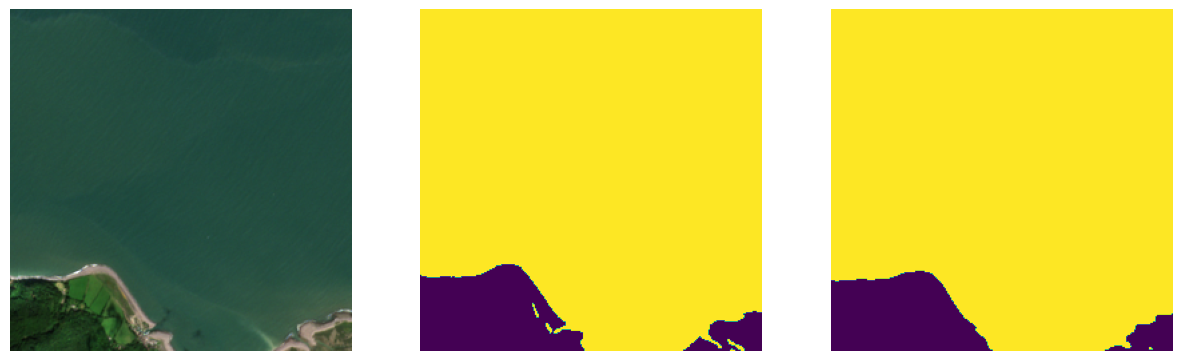

In [34]:
# Display some predictions
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],satellite=satellite,contrast=0.2)
target = test_targets[i]
pred = preds[i]

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

100
accuracy: 89.5859
balanced_accuracy: 90.8496
precision: 85.0197
recall: 95.5754
f1: 88.5439
mse: 5.6835
fom: 50.4756


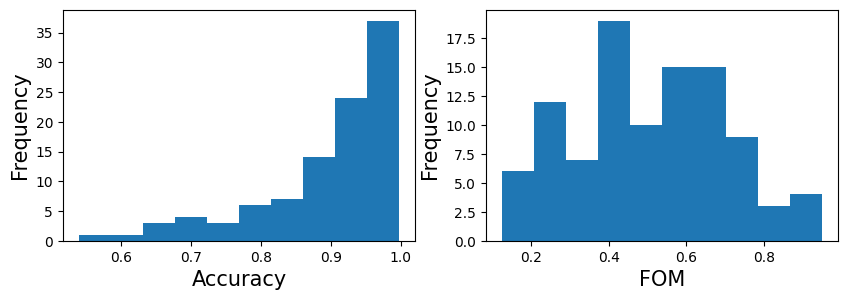

In [27]:
# Finetune
targets, preds = eval.get_preds(model,finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(finetune_targets ,preds)
finetune_metrics['rough_model'] = metrics
eval.display_metrics(metrics,arr)


# Finetuned model

In [28]:
# Set device
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = network.U_Net(12,2).to(device)

# Load saved model 
#model = torch.load('../models/LANDSAT-UNET-20JUL23.pth', map_location=torch.device('cpu') )
state_dict = torch.load(f'../../models/{swed_finetune}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

98
accuracy: 92.4495
balanced_accuracy: 90.553
precision: 90.1739
recall: 95.8097
f1: 91.6679
mse: 4.2879
fom: 57.3108


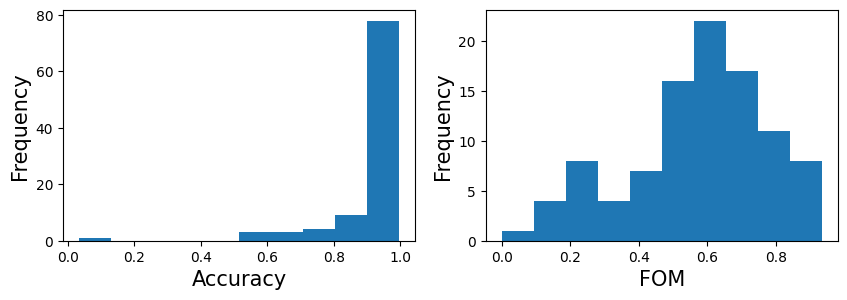

In [29]:
# Test
targets, preds = eval.get_preds(model,test_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(test_targets ,preds)
test_metrics['finetune_model'] = metrics
eval.display_metrics(metrics,arr)

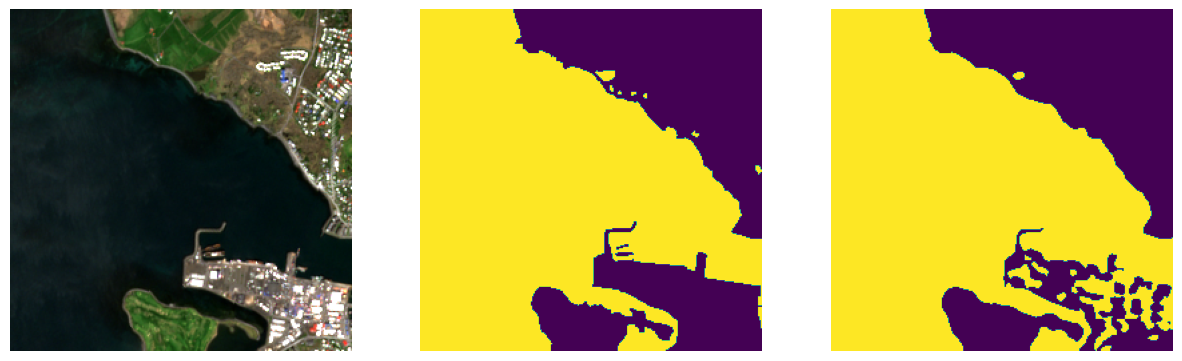

In [30]:
# Display some predictions
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],satellite=satellite,contrast=0.2)
target = test_targets[i]
pred = preds[i]

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

100
accuracy: 95.4717
balanced_accuracy: 95.5221
precision: 94.3303
recall: 94.4964
f1: 93.7621
mse: 4.9842
fom: 67.9815


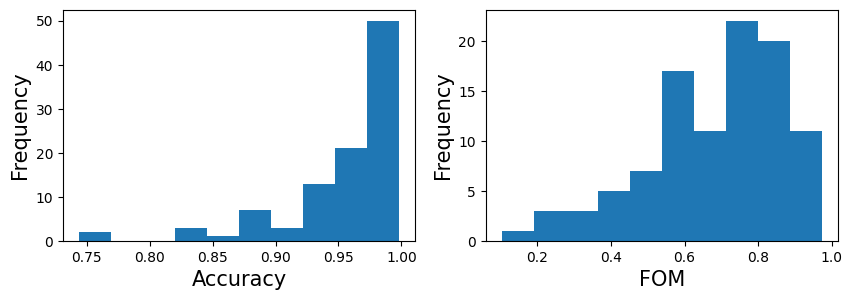

In [31]:
# Finetune
targets, preds = eval.get_preds(model,finetune_paths,target_pos=-1,incl_bands=incl_bands,satellite=satellite,batch_size=10)
print(len(preds))

metrics, arr = eval.eval_metrics(finetune_targets ,preds)
finetune_metrics['finetune_model'] = metrics
eval.display_metrics(metrics,arr)

# Final Metrics Table

In [34]:
 # Test metrics
df_test_metrics = pd.DataFrame(test_metrics)

df_test_metrics = df_test_metrics[['original','superpixels','rough_model','finetune_model']]
df_test_metrics = df_test_metrics.transpose()
df_test_metrics = df_test_metrics[['accuracy','precision','recall','f1','fom']]
np.round(df_test_metrics,3)

,accuracy,precision,recall,f1,fom
original,0.885,0.894,0.848,0.847,0.538
superpixels,0.943,0.938,0.943,0.933,0.602
rough_model,0.870,0.823,0.944,0.858,0.421
finetune_model,0.924,0.902,0.958,0.917,0.573


In [35]:
# Finetune metrics
df_finetune_metrics = pd.DataFrame(finetune_metrics)

df_finetune_metrics = df_finetune_metrics[['original','superpixels','rough_model','finetune_model']]
df_finetune_metrics = df_finetune_metrics.transpose()
df_finetune_metrics = df_finetune_metrics[['accuracy','precision','recall','f1','fom']]

np.round(df_finetune_metrics,3)

,accuracy,precision,recall,f1,fom
original,0.934,0.919,0.918,0.905,0.633
superpixels,0.945,0.942,0.930,0.922,0.692
rough_model,0.896,0.850,0.956,0.885,0.505
finetune_model,0.955,0.943,0.945,0.938,0.680


# Archive

5: 0.4857330322265625


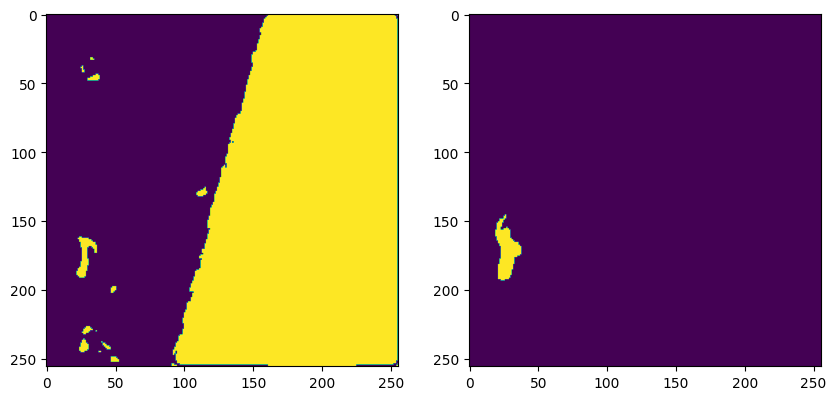

In [40]:
for i in range(75):
    pred = preds[i]
    target = finetune_targets[i]

    accuracy = np.sum(pred == target) / np.size(pred)

    if accuracy < 0.6:
        print(f"{i}: {accuracy}")

        fig, ax = plt.subplots(1,2,figsize=(10,5))
        ax[0].imshow(pred)
        ax[1].imshow(target)
        